# WAIC・WBIC
## WAIC・WBICについて
***
- WAICは予測に扱うモデルを選択する指標
- WBICは統計モデルと事前分布における最適な組み合わせを選択する指標

## 分析
***
- 混合正規分布を真の分布としたときに下記モデリングでのWAIC・WBICを計算
    - 正規分布
    - 標準正規分布の混合分布

In [7]:
import warnings
warnings.filterwarnings('ignore')
import pymc3 as pm
from pymc3.distributions.dist_math import bound
import theano.tensor as tt
import theano
import numpy as np
np.random.seed(seed=32)

## データセット作成

In [8]:
N = 100
a_true = 0.6
mean1 = 0
mean2 = 3
sd = 1
Y = np.random.randn(N)
Y[:int(N*a_true)] = Y[:int(N*a_true)] * sd + mean1
Y[int(N*a_true):] = Y[int(N*a_true):] * sd + mean2

## 逆温度付きの正規分布

In [9]:
def normal_logp(value, mu, sd):
    tau = sd ** -2
    return (-tau * (value - mu)**2 + tt.log(tau / np.pi / 2.)) / 2

In [10]:
class NormalWithInverseTemperature(pm.Continuous):
    def __init__(self, beta=1, mu=0, sd=1, **kwargs):
        self.beta = beta
        self.sd = sd
        self.tau = sd**-2
        self.mu = mu
        super(NormalWithInverseTemperature, self).__init__(**kwargs)
    
    def logp(self, value):
        return bound(normal_logp(value, self.mu, self.sd), self.sd > 0) * self.beta

In [11]:
class MixtureNormalWithInverseTemperature(pm.Continuous):
    def __init__(self, a, mu, sd, beta=1, **kwargs):
        self.beta = beta
        self.sd = sd
        self.mu = mu
        self.a = a
        super(MixtureNormalWithInverseTemperature, self).__init__(**kwargs)

    def logp(self, value):
        sd = self.sd
        mu = self.mu
        a = self.a

        return pm.math.logsumexp(
            pm.math.stack([pm.math.log(1-a) + normal_logp(value, 0, sd),
                           pm.math.log(a) + normal_logp(value, mu, sd)])) * self.beta

## 逆温度

In [12]:
beta = 1/np.log(N)

## モデリング（正規分布）

In [13]:
with pm.Model() as model1:
    mu = pm.Normal("mu", mu=0, sd=1e4)
    sd = pm.HalfStudentT("sd", nu=3, sd=1e2)
    obs = dict()
    for i in range(N):
        obs[i] = NormalWithInverseTemperature(f"obs_{i}", mu=mu, sd=sd, observed=Y[i], beta=beta)

    y_pred = NormalWithInverseTemperature("pred", mu=mu, sd=sd, beta=beta, testval=0) # ppc
    log_likes = pm.Deterministic("log_likes", pm.math.stack([obs[i].logpt / beta for i in range(N)])) # to calc wbic
    
    trace1 = pm.sample(2000, tune=500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [pred, sd, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:16<00:00, 610.80draws/s]


## サンプリング結果

In [14]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,1.267253,0.422240,0.004842,0.426495,2.098997,6515.455070,1.000256
pred,1.262877,4.205781,0.049410,-7.281878,9.285948,7619.647968,0.999846
sd,1.922319,0.331134,0.003968,1.343130,2.594741,6628.802147,0.999984
log_likes__0,-1.965284,0.199345,0.002223,-2.378585,-1.605887,6877.569773,1.000364
log_likes__1,-1.593524,0.169758,0.002189,-1.927176,-1.271772,6173.211694,1.000079
log_likes__2,-1.650888,0.169268,0.002165,-1.987473,-1.333333,6242.011381,1.000208
log_likes__3,-1.792113,0.176285,0.002126,-2.138001,-1.460034,6502.601491,1.000358
log_likes__4,-1.616934,0.169341,0.002183,-1.947287,-1.294607,6194.126790,1.000142
log_likes__5,-1.650679,0.169266,0.002165,-1.987456,-1.333158,6241.667339,1.000208
log_likes__6,-1.587868,0.169634,0.002136,-1.919192,-1.263325,6195.664708,0.999983


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12aee2b00>,
      dtype=object)

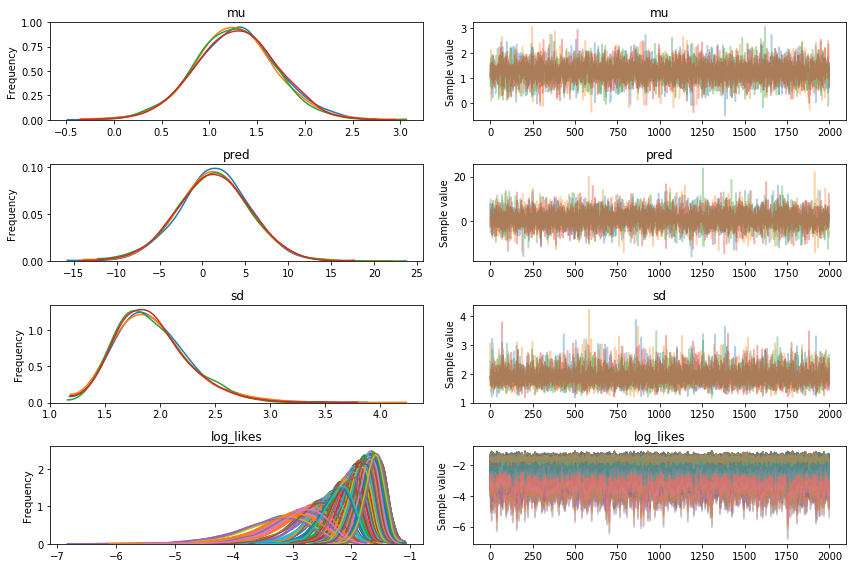

In [15]:
pm.traceplot(trace1)

## モデリング（混合正規分布）

In [16]:
with pm.Model() as model2:
    a = pm.Uniform('a', lower=0, upper=1)
    mu = pm.Normal('mu', mu=0, sd=1e4)
    obs = dict()
    for i in range(N):
        obs[i] = MixtureNormalWithInverseTemperature(f"obs_{i}", a=a, mu=mu, sd=1, observed=Y[i], beta=beta)
    
    y_pred = MixtureNormalWithInverseTemperature("pred", a=a, mu=mu, sd=1, testval=0, beta=beta)
    log_likes = pm.Deterministic("log_likes", pm.math.stack([obs[i].logpt / beta for i in range(N)]))
    
    trace2 = pm.sample(2000, tune=500, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [pred, mu, a]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:07<00:00, 148.49draws/s]


## サンプリング結果

In [17]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,3.017173,0.455228,0.005637,2.142242,3.913845,6505.497447,1.000829
pred,1.386116,2.851473,0.036219,-3.798049,6.791605,6265.949341,0.999894
a,0.413650,0.117954,0.001542,0.199093,0.656165,7158.190644,1.000505
log_likes__0,-1.527419,0.208542,0.002673,-1.932117,-1.148780,7252.704115,1.000557
log_likes__1,-1.764098,0.156280,0.001774,-2.083849,-1.474395,8326.204693,1.000552
log_likes__2,-1.566930,0.169331,0.002137,-1.891587,-1.252808,8150.307192,1.000516
log_likes__3,-1.454618,0.196979,0.002531,-1.849679,-1.103009,7502.566562,1.000549
log_likes__4,-1.655708,0.158253,0.001926,-1.960792,-1.360665,8548.681073,1.000505
log_likes__5,-1.567345,0.169265,0.002136,-1.894064,-1.255468,8152.548420,1.000516
log_likes__6,-2.007611,0.244795,0.002877,-2.456087,-1.499973,6288.669033,1.000917


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1359c9080>,
      dtype=object)

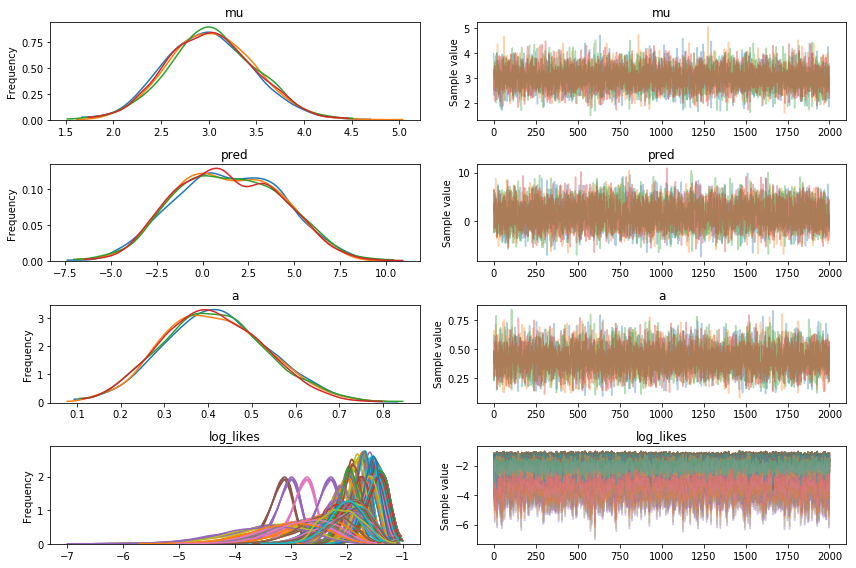

In [18]:
pm.traceplot(trace2)

## WAICの計算

In [22]:
waic1 = pm.waic(trace1, model1)
waic2 = pm.waic(trace2, model2)
print('model1｜WAIC = {0}'.format(waic1.WAIC))
print('model2｜WAIC = {0}'.format(waic2.WAIC))

model1｜WAIC = 87.98024930487642
model2｜WAIC = 84.97283886428576


## WBICの計算

In [20]:
def wbic(log_likelihood):
    return - np.sum(log_likelihood, axis=1).mean()

print('model1｜WBIC = {0}'.format(wbic(trace1["log_likes"])))
print('model2｜WBIC = {0}'.format(wbic(trace2["log_likes"])))

model1｜WBIC = 201.86076321260654
model2｜WBIC = 194.55660258745945
